In [ ]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('/content/sample_data/student_spending_cleaned.csv')
df.head()

,Unnamed: 0,age,gender,year_in_school,major,monthly_income_idr,financial_aid_idr,tuition_idr,housing_idr,food_idr,transportation_idr,books_supplies_idr,entertainment_idr,personal_care_idr,technology_idr,health_wellness_idr,miscellaneous_idr,preferred_payment_method
0,0,19,Non-binary,Freshman,Psychology,14370000,4050000,89085000,10635000,4440000,1845000,2820000,615000,1170000,2010000,1905000,1080000,Credit/Debit Card
1,1,24,Female,Junior,Economics,15090000,13125000,73620000,8355000,5475000,1275000,3780000,1110000,1380000,3390000,1935000,1020000,Credit/Debit Card
2,2,24,Non-binary,Junior,Economics,11010000,13920000,45765000,9990000,3300000,2055000,1485000,1950000,345000,3585000,1680000,1995000,Cash
3,3,23,Female,Senior,Computer Science,9255000,3975000,74025000,9780000,4335000,1710000,3345000,1485000,450000,2445000,1575000,825000,Mobile Payment App
4,4,20,Female,Senior,Computer Science,12150000,7830000,58305000,12375000,5580000,2520000,2910000,720000,1065000,1320000,1065000,1560000,Credit/Debit Card


In [ ]:
columns_to_drop = ['Unnamed: 0', 'tuition_idr', 'year_in_school', 'major', 'books_supplies_idr', 'preferred_payment_method']
df = df.drop(columns=columns_to_drop)

# 3. Gabungkan kolom terkait
# Gabungkan 'monthly_income_idr' dan 'financial_aid_idr' menjadi 'total_income_idr'
df['total_income_idr'] = df['monthly_income_idr'] + df['financial_aid_idr']

# Gabungkan 'personal_care_idr' dan 'health_wellness_idr' menjadi 'personal_health_idr'
df['personal_health_idr'] = df['personal_care_idr'] + df['health_wellness_idr']

# Opsional: Gabungkan 'entertainment_idr' dan 'miscellaneous_idr' menjadi 'leisure_idr'
df['leisure_idr'] = df['entertainment_idr'] + df['miscellaneous_idr'] + df['technology_idr']

df['total_expenses'] = (
    df['housing_idr'] + df['food_idr'] + df['transportation_idr'] +
    df['personal_health_idr'] + df['leisure_idr']
)

# 4. Hapus kolom yang telah digabung
df = df.drop(columns=['monthly_income_idr', 'financial_aid_idr', 'personal_care_idr', 'health_wellness_idr', 'entertainment_idr', 'miscellaneous_idr', 'technology_idr'])

# 5. Tampilkan beberapa baris dari dataset yang telah diproses
print("Dataframe setelah pengolahan:")
print(df.info())


Dataframe setelah pengolahan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  1000 non-null   int64 
 1   gender               1000 non-null   object
 2   housing_idr          1000 non-null   int64 
 3   food_idr             1000 non-null   int64 
 4   transportation_idr   1000 non-null   int64 
 5   total_income_idr     1000 non-null   int64 
 6   personal_health_idr  1000 non-null   int64 
 7   leisure_idr          1000 non-null   int64 
 8   total_expenses       1000 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 70.4+ KB
None


In [ ]:
df_clean = df.copy()

# Preprocessing kolom gender dan spending_level menjadi numerik
le = LabelEncoder()
df_clean['gender'] = le.fit_transform(df_clean['gender'])  # Ubah gender (Male, Female, Non-binary) ke (0, 1, 2)


# Pastikan semua kolom adalah numerik


# Variance-based weights
weights = df_clean.var() / df_clean.var().sum()
print(weights)

age                    8.658647e-14
gender                 1.034653e-14
housing_idr            1.058672e-01
food_idr               2.730203e-02
transportation_idr     6.851652e-03
total_income_idr       6.320287e-01
personal_health_idr    1.080922e-02
leisure_idr            3.383464e-02
total_expenses         1.833065e-01
dtype: float64


In [ ]:
# Korelasi dengan total_expenses
correlations = df_clean.corr()['total_expenses']
weights = correlations / correlations.sum()
print(weights)


age                    0.009166
gender                 0.012129
housing_idr            0.241472
food_idr               0.121169
transportation_idr     0.067517
total_income_idr       0.003585
personal_health_idr    0.078885
leisure_idr            0.142411
total_expenses         0.323666
Name: total_expenses, dtype: float64


In [ ]:
weights = {
    'housing_idr': 0.105909,
    'food_idr': 0.027313,
    'transportation_idr': 0.006854,
    'personal_health_idr': 0.010813,
    'leisure_idr': 0.014858,
}

# Hitung skor berbasis bobot
df['weighted_score'] = (
    df['housing_idr'] * weights['housing_idr'] +
    df['food_idr'] * weights['food_idr'] +
    df['transportation_idr'] * weights['transportation_idr'] +
    df['personal_health_idr'] * weights['personal_health_idr'] +
    df['leisure_idr'] * weights['leisure_idr']
)

# Normalisasi ke skala 0-100
df['score'] = (df['weighted_score'] - df['weighted_score'].min()) / (
    df['weighted_score'].max() - df['weighted_score'].min()
) * 100

print(df[['weighted_score', 'score']])

     weighted_score      score
0       1348556.430  50.883752
1       1161008.475  32.985917
2       1296025.845  45.870721
3       1258458.330  42.285626
4       1556822.985  70.758777
..              ...        ...
995     1740163.770  88.255119
996     1050529.995  22.442877
997     1412963.265  57.030142
998     1088933.475  26.107748
999     1244902.170  40.991952

[1000 rows x 2 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1000 non-null   int64  
 1   gender               1000 non-null   object 
 2   housing_idr          1000 non-null   int64  
 3   food_idr             1000 non-null   int64  
 4   transportation_idr   1000 non-null   int64  
 5   total_income_idr     1000 non-null   int64  
 6   personal_health_idr  1000 non-null   int64  
 7   leisure_idr          1000 non-null   int64  
 8   total_expenses       1000 non-null   int64  
 9   weighted_score       1000 non-null   float64
 10  score                1000 non-null   float64
dtypes: float64(2), int64(8), object(1)
memory usage: 86.1+ KB


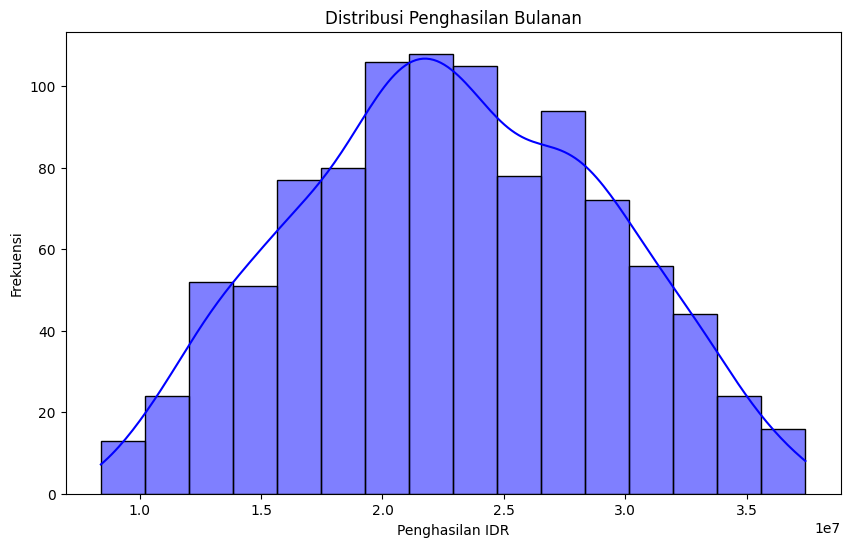

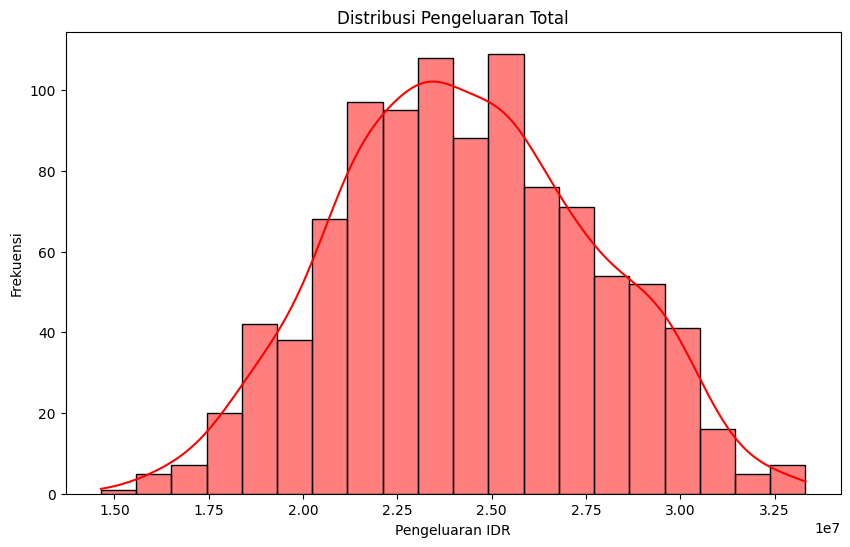

In [ ]:
import seaborn as sns

# Plot distribusi penghasilan
plt.figure(figsize=(10, 6))
sns.histplot(df['total_income_idr'], kde=True, color='blue')
plt.title('Distribusi Penghasilan Bulanan')
plt.xlabel('Penghasilan IDR')
plt.ylabel('Frekuensi')
plt.show()

# Plot distribusi pengeluaran total
plt.figure(figsize=(10, 6))
sns.histplot(df['total_expenses'], kde=True, color='red')
plt.title('Distribusi Pengeluaran Total')
plt.xlabel('Pengeluaran IDR')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
df.describe()

,age,housing_idr,food_idr,transportation_idr,total_income_idr,personal_health_idr,leisure_idr,total_expenses,weighted_score,score
count,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000
mean,21.675000,1.044009e+07,3.789630e+06,1.869555e+06,2.288132e+07,2.625135e+06,5.580420e+06,2.430483e+07,1.333319e+06,49.429638
std,2.322664,2.568279e+06,1.304244e+06,6.533699e+05,6.275233e+06,8.206514e+05,1.451918e+06,3.379484e+06,2.741535e+05,26.162659
min,18.000000,6.015000e+06,1.500000e+06,7.500000e+05,8.400000e+06,7.800000e+05,1.605000e+06,1.464000e+07,8.153554e+05,0.000000
25%,20.000000,8.081250e+06,2.625000e+06,1.320000e+06,1.841625e+07,2.010000e+06,4.537500e+06,2.185125e+07,1.087405e+06,25.961841
50%,22.000000,1.056750e+07,3.825000e+06,1.845000e+06,2.280000e+07,2.625000e+06,5.580000e+06,2.414250e+07,1.338566e+06,49.930324
75%,24.000000,1.255875e+07,4.950000e+06,2.433750e+06,2.765250e+07,3.243750e+06,6.570000e+06,2.672250e+07,1.558912e+06,70.958098
max,25.000000,1.500000e+07,6.000000e+06,3.000000e+06,3.742500e+07,4.470000e+06,9.345000e+06,3.331500e+07,1.863236e+06,100.000000


Text(0.5, 1.0, 'Correlation Matrix')

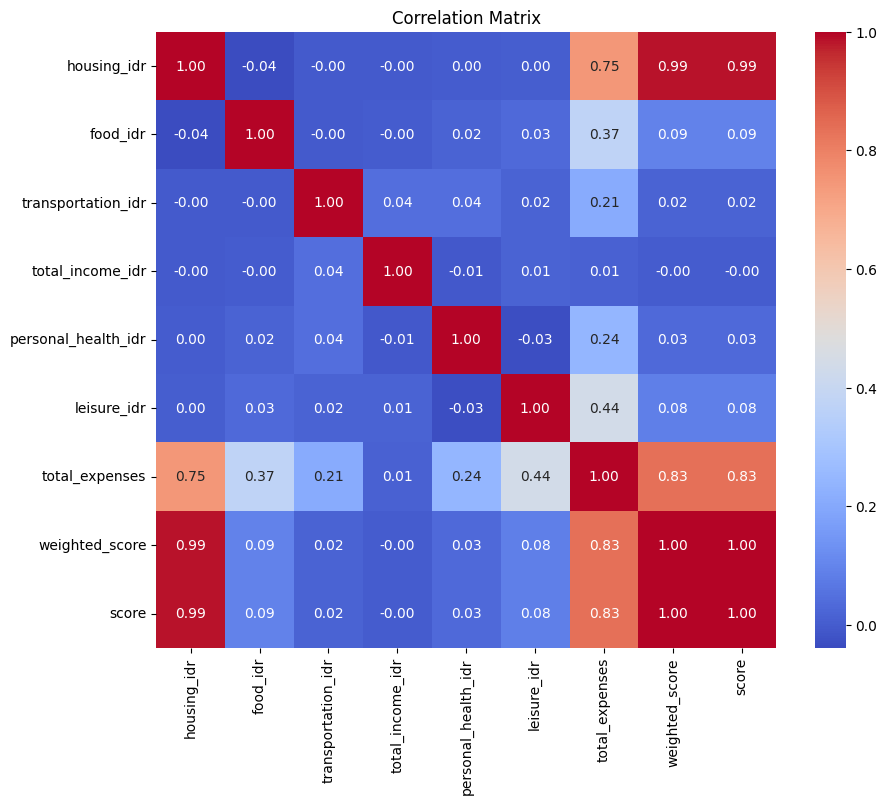

In [20]:
selected_columns = [
    "housing_idr", "food_idr", "transportation_idr", "total_income_idr",
    "personal_health_idr", "leisure_idr", "total_expenses", "weighted_score", "score"
]

df_selected = df[selected_columns]

# Plotting the correlation heatmap for the selected features
correlation_matrix = df_selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix")